# 机器学习 HW2
各位同学好，在这个notebook中，我们会带领大家逐步实现一个图像分类任务，一共包含以下几个主要部分：
1. **数据集**：加载训练和测试使用的animal10数据集
2. **模型**：构建实验所需要的ResNet34神经网络
3. **训练和测试**：构建模型训练和测试的整个pipeline

其中每一部分会涉及到一些代码填空题，需要大家根据提示补充相应的代码后才能继续执行后续代码块。如果对如何使用pytorch实现图像分类不熟悉的话，建议大家仔细回顾我们在第一次作业中为大家提供的[**实例代码**](https://www.kaggle.com/code/guluguluwulu/pytorch-logistic-regression)，相信会对大家完成本次作业有帮助。

## 导入必要的库

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import v2
# PyTorch 2.0 之后的版本建议使用 torchvision.transforms.v2 来代替 torchvision.transforms
from torch.utils.data import Dataset, DataLoader
import glob 
import random
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## 固定随机数种子（**必须执行该代码块！**）

In [2]:
# 设置随机数种子，保证每个人的训练集、验证集和测试集都相同
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(2024)

## GPU设置
1. 本次作业需要使用 GPU 对模型进行加速。请搭建先右边栏的 “ACCELERATOR” 选项设置为 **GPU T4×2**。

2. 由于 Kaggle 对 GPU 的使用有一定的时间限制 (每周20卡时)，所以当你只想使用 CPU 对程序进行调试时，可以将 “ACCELERATOR” 选项设置为 **None**。
<div style="text-align:center;">
    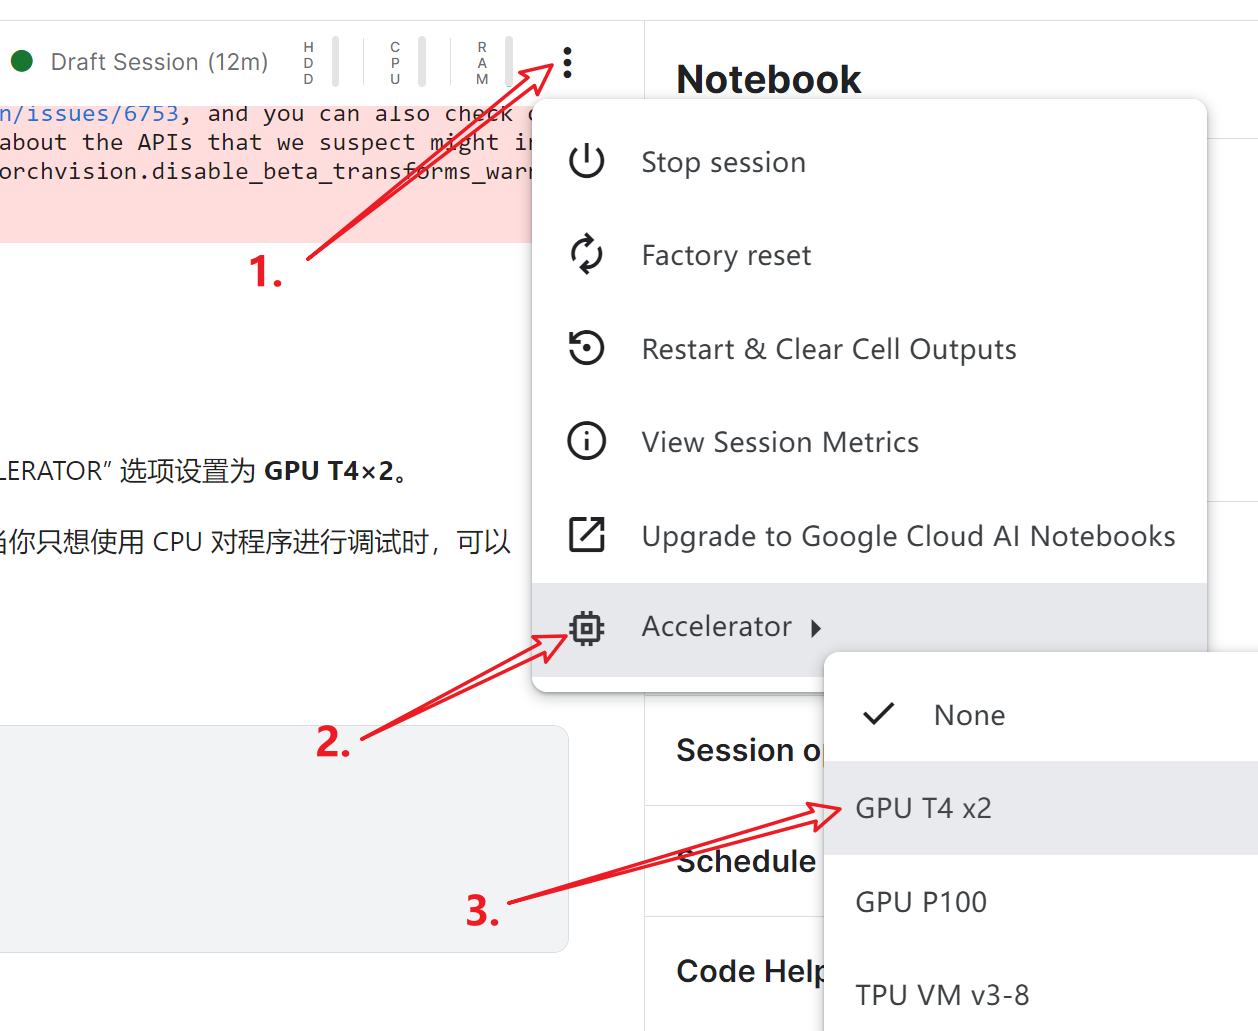
</div>

In [3]:
print(torch.__version__)
# 检查GPU是否可用，并检查是否正确选择了GPU类型
# 在使用 cpu 环境对程序进行调试的时候可以先注释掉这2行代码
assert torch.cuda.is_available(), "Please select GPU accelerator"
assert torch.cuda.device_count() == 2, "Please select accelerator as 'T4 x 2'"
# 检查是否按要求设定了随机数种子
assert torch.initial_seed() == 2024, "Please set your random seed first!"

2.0.0


In [4]:
ngpu = torch.cuda.device_count()  # 可用的 GPU 数量. 0 表示使用 CPU.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


## 加载 Animals-10 数据集

该数据集包含约 2.8 万张动物图像，共属于 10 个类别，包括狗、猫、马、蜘蛛、蝴蝶、鸡、羊、牛、松鼠、大象等。为模拟真实情况，数据集中可能存在一些错误数据。

### 加载数据

In [5]:
# 原来的数据目录名称为意大利语，这里转换为英语
classes_dict = { 
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

classes = ["dog", "horse", "elephant", "butterfly", "chicken", "cat", "cow", "sheep", "spider", "squirrel",]

data = {
    "path":[],
    "label":[]
}

data_dir="/kaggle/input/animals10/raw-img"

### 数据集样本展示

分别使用 pandas 库和 matplotlib 库来展示部分的数据。

In [6]:
for label_it, label_en in classes_dict.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')

    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

,path,label
0,/kaggle/input/animals10/raw-img/cane/OIP-6p-HH...,dog
1,/kaggle/input/animals10/raw-img/cane/OIP-A1GkR...,dog
2,/kaggle/input/animals10/raw-img/cane/OIP-GZmwq...,dog
3,/kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...,dog
4,/kaggle/input/animals10/raw-img/cane/OIP-bbrbp...,dog


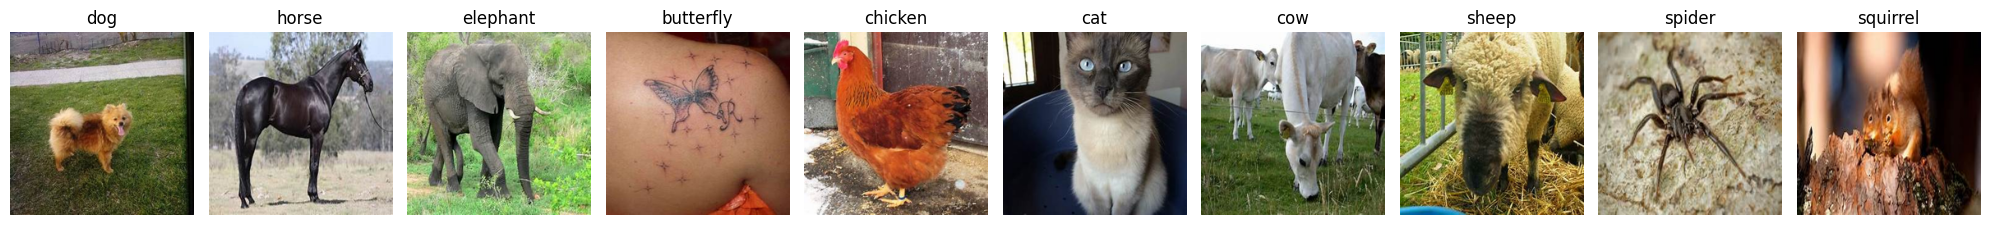

In [7]:
plt.figure(figsize = (20, 7))

for idx, i in enumerate(df_data.label.unique()):
    plt.subplot(1, 10, idx + 1)
    df = df_data[df_data['label'] == i].reset_index(drop=True)
    
    image_path = df.loc[random.randint(0, len(df) - 1), 'path']
    img = Image.open(image_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    
plt.tight_layout()
plt.show()

### 使用 Pytorch 加载数据集

#### **数据增强（Data Augmentation）**

在深度学习中，要求样本数量充足，样本数量越多，训练出来的模型效果越好，模型的泛化能力越强。但是实际中，样本数量不足或者样本质量不够好，这时就需要对样本做数据增强，即通过一定的方式改变输入数据，以生成更多样的训练样本，从而提高模型的泛化能力和效果。数据增强可以减少模型对某些特征的过度依赖，从而避免过拟合。

例如在图像分类任务中，对于输入的图像可以进行一些简单的平移、缩放、颜色变换等操作，这些操作不会改变图像的类别，但可以增加训练样本的数量。这些增强后的样本可以帮助模型更好地学习和理解图像的特征，提高模型的泛化能力和准确率。

### 任务 1（10 Points）
请在下方代码的空白处添加一些数据增强函数，并在后面“测试 transform 效果”的代码块输出5张不同样式的数据增强后的图片。<br>
**数据增强后的图片需要保证长宽均为224，通道数为3。**

PyTorch 官方提供了一些包装好的数据增强 api。具体可参考 https://pytorch.org/vision/stable/transforms.html

In [8]:
"""
测试时使用的数据增强：
在测试时，test_tfm 可以不使用 data augmentation，
但也有一种手段叫做 test time augmentation (TTA)，
感兴趣的同学可以自行去了解并实现，这里不做要求
"""
test_tfm = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

"""
训练时使用的数据增强：
请大家补充合适的数据增强方法，需要注意的是不同增强手段会对模型最终的准确率有影响
大家可以通过调试找出合适的数据增强方式
"""
train_tfm = v2.Compose([
    v2.Resize((224,224)),
    
    # =========== 请在此处自行补充一些数据增强方式 ===========
    v2.RandomRotation(30),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=(224, 224),scale = (0.5,1)),
    v2.TrivialAugmentWide(),
    
    # ===================================================

    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


#### **数据集 (Dataset)**

PyTorch 提供了 ```torch.utils.data.Dataset``` 类来定义数据集。用户可以继承该类从而实现自定义数据集。自定义的数据集一般需要实现以下3个类方法：
+ ```__init__``` 进行数据集的初始化
+ ```__len__``` 返回数据集包含的数据数量
+ ```__getitem__``` 根据索引从数据集中获取对应的数据

### 任务 2（10 Points）
请对数据集的 ```__getitem__``` 函数进行补充，使程序能正常运行。

In [9]:
# 定义 AnimalDataset 数据集
class AnimalDataset(Dataset):
    
    def __init__(self, path_lst, label_lst, tfm):
        super(AnimalDataset).__init__()
        self.path_lst = path_lst
        self.label_lst = label_lst
        self.transform = tfm

    def __len__(self):
        return len(self.path_lst)

    def __getitem__(self, idx):
        
        """
        以下是一段空缺的代码，你需要对 AnimalDataset 类的 __getitem__ 函数进行补充。
        目标：
          根据参数 idx(数据的索引) 从数据集的 path_lst 和 label_lst 中取出对应的图片路径 fname 和标签 label
        """
        # ========== 请在此处补充你的代码 ==========
        label = self.label_lst[idx]
        fname = self.path_lst[idx]
        # =======================================
        
        img = Image.open(fname)
        img = self.transform(img)
        
        return img, label

以下函数用于将数据集划分为训练集、验证集和测试集。这个函数无需进行修改。

**注意：如果你修改了任务1和任务2的代码，那么再次运行以下函数将无法得到新的结果。函数会返回其第一次执行的结果。因此如果你需要修改前面的代码，在修改后，请点击右上角的重启环境按钮，再重新执行所有的代码块。**

In [10]:
def get_datasets(data_dir, sample_ratio=0.25, split_ratio=[0.7, 0.1, 0.2]):
    """
    按照一定比例（7:1:2），手动将数据集划分为训练集、验证集和测试集。
    由于之前设定了随机数种子，因此每位同学得到的训练集、验证集和测试集都是一样的。这个函数无需进行修改。
    """
    assert sum(split_ratio) == 1.0
    global train_dataset, val_dataset, test_dataset
    try:  # 保证函数多次执行时结果不变
        if train_dataset is not None:
            print("datasets exist!")
            return train_dataset, val_dataset, test_dataset
    except NameError:
        pass
    
    data_all = defaultdict(list)
    for i, (label_it, label_en) in enumerate(classes_dict.items()):
        paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')
        data_all["path"].extend(paths)
        data_all["label"].extend([i] * len(paths))
    n_data_all = len(data_all["path"])
    # 下面的代码首先生成了一个从 0 到 n_data_all 的乱序的全排列，随后再取前 k 个数值。
    # 这是一种很方便和快速的随机采样方法。
    rp = torch.randperm(n_data_all)
    n_sampled_data = int(n_data_all * sample_ratio)
    n_train_data = int(n_sampled_data * split_ratio[0])
    n_val_data = int(n_sampled_data * split_ratio[1])
    n_test_data = n_sampled_data - n_train_data - n_val_data
    print("number of training image:", n_train_data)
    print("number of validation image:", n_val_data)
    print("number of testing image:", n_test_data)
    
    path_lsts = [[], [], []]
    label_lsts = [[], [], []]
    
    for i, k in enumerate(rp):
        idx = k.item()
        if i >= n_sampled_data:
            break
        if i < n_train_data:
            path_lsts[0].append(data_all["path"][idx])
            label_lsts[0].append(data_all["label"][idx])
        elif i < n_train_data + n_val_data:
            path_lsts[1].append(data_all["path"][idx])
            label_lsts[1].append(data_all["label"][idx])
        else:
            path_lsts[2].append(data_all["path"][idx])
            label_lsts[2].append(data_all["label"][idx])
    
    train_dataset = AnimalDataset(path_lsts[0], label_lsts[0], tfm=train_tfm)
    val_dataset = AnimalDataset(path_lsts[1], label_lsts[1], tfm=test_tfm)
    test_dataset = AnimalDataset(path_lsts[2], label_lsts[2], tfm=test_tfm)
    
    return train_dataset, val_dataset, test_dataset

    
train_dataset, val_dataset, test_dataset = get_datasets(data_dir="/kaggle/input/animals10/raw-img")

number of training image: 4236
number of validation image: 605
number of testing image: 1211


### 测试代码1： 对`__getitem__`函数进行测试
**以下代码用于验证 \_\_getitem\_\_ 函数以及数据增强后输出tensor的形状，通过该部分测试可以得到任务2中对应的分数**

In [11]:
correct_labels = train_dataset.label_lst[:50]
your_labels = [train_dataset[_][1] for _ in range(50)]

if your_labels == correct_labels:
    print("__getitem__ 函数验证正确！")
else:
    print("__getitem__ 函数验证错误！")

print("")
    
img = train_dataset[0][0]
if img.size() == torch.Size([3, 224, 224]):
    print("数据增强输出形状正确！")
else:
    print("数据增强输出形状错误！")

__getitem__ 函数验证正确！

数据增强输出形状正确！


### 测试代码2： 对`train_tfm`数据增强效果进行测试
**以下代码用于验证 train_tfm 数据增强的效果，通过该部分测试可以得到任务1中对应的分数**。

要求：下面代码展示出的5张图片都是经过数据增强转换过的

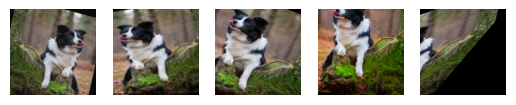

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 5)

for i in range(5):
    img, label = train_dataset[7]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_img = img.cpu().numpy().transpose((1, 2, 0)) * std + mean
    # print(unnormalized_img)

    # 确保像素值在合适范围内
    unnormalized_img = np.clip(unnormalized_img, 0, 1)

    # 显示图像
    ax[i].imshow(unnormalized_img)
    ax[i].axis('off')

fig.show()

#### **定义 DataLoader**

DataLoader 根据一定的 batch size 从数据集中取出批量化的数据，并将其逐份输入到模型中。这里直接采用 Pytorch 封装好的类 ```torch.utils.data.DataLoader```。

In [13]:
# 针对 3 个数据集生成 3 个 dataloader
batch_size = 64  # batch size 可以自行调整, 它的值可能也对模型的准确率产生影响
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 构造 ResNet34 模型
### ResNet 介绍

ResNet 即残差网络，它由何恺明、张祥雨、任少卿和孙剑在 2015 年的论文《**[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)**》中首次提出，并可在多种任务中作为骨干网络进行特征提取。它通过跳跃连接的方式较好地解决了梯度消失问题，使得人们得以训练超过150层的深度神经网络。

卷积神经网络有一个主要缺点：梯度消失问题，即在反向传播过程中，梯度值会显著减小，这使得网络权重几乎没有变化。ResNet 使用了**跳跃连接**的方法来解决该问题。跳跃连接即打通一条直接跳过神经网络某一层的数据连接通道，将输入数据和网络的输出直接相加。

### ResNet 网络结构

常用的 ResNet 结构包括 ResNet-18、ResNet-34、ResNet-50、ResNet-101 和 ResNet-152，每种结构都有着不同的残差块结构和不同数量的残差块，如下图所示。

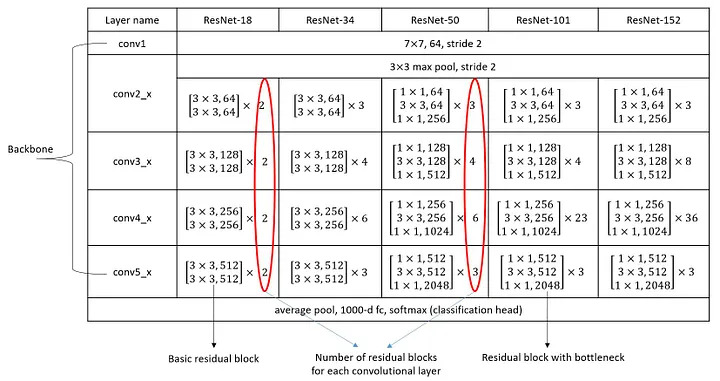

每种 ResNet 架构都由 5 个卷积层（conv1、conv2_x — conv5_x）、1 个平均池化层、1 个全连接层和 1 个 softmax 层组成。 其中的五个卷积层是骨干网络，用于提取图像特征，后面的层被用于图像分类任务。

在 ImageNet 数据集上预训练的 ResNet 骨干网络被广泛用于提取不同分辨率级别的特征（即经过 conv2_x、conv3_x、conv4_x 和 conv5_x 之后的特征图）。 这些特征之后会通过特定的网络，并针对特定任务进行微调，例如图像分类、目标检测、语义分割等。

五种 ResNet 架构使用残差块作为基本块。 从 conv2_x 到 conv5_x，每个复合卷积层会使用不同数量的残差块。如上图中红色椭圆圈起来的地方所示，ResNet-18 中 conv2_x、conv3_x、conv4_x 和 conv5_x 使用的残差块的数量分别为 2、2、2 和 2。而在 ResNet-50 中，conv2_x、conv3_x、conv4_x 和 conv5_x 使用的残差块的数量分别为 3、4、6 和 3。

ResNet-18 和 ResNet-34 使用的残差块与 ResNet-50、ResNet-101 和 ResNet-152 使用的残差块的结构有所不同，从 ResNet-50 开始，网络采用了瓶颈结构，通过交替 1x1 和 3x3 卷积来减少模型参数。 如下所示，与使用 (3x3,64) 和 (3x3,256) 两种卷积相比，模型参数量从 294912 减少为 69632。瓶颈结构的另一个优点是，更多的卷积引入了更多的激活函数。因此，模型的非线性特性和兼容性得以增加。

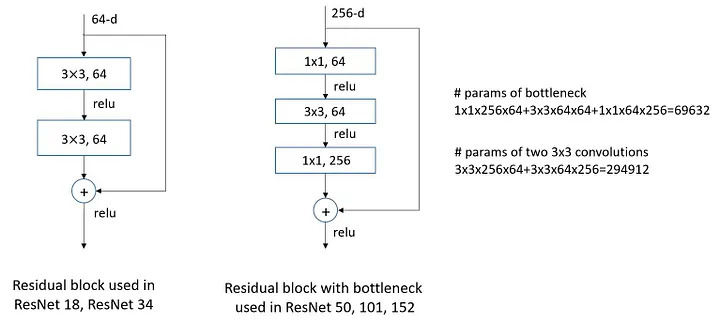

ResNet 从 conv2_x 到 conv5_x 提取了分辨率原来越低的特征。值得注意的是，conv3_x、conv4_x 和 conv5_x 层里的第一个残差块的第一个 3x3 卷积的步距为 2，这是为了对特征图进行下采样，以获得更大的感受野。因此，需要特别注意这些改变分辨率的残差块，注意输入和输出特征图的通道数和分辨率，据此调整跳跃连接的执行。

下图分别展示了在 ResNet 18、34 以及 ResNet 50、101、152 的 conv3_x 层的第一个残差块中，跳跃连接通道使用了一个步距为 2 的 1x1 卷积，以匹配输入和输出的特征图的空间维度以及通道数的差异。

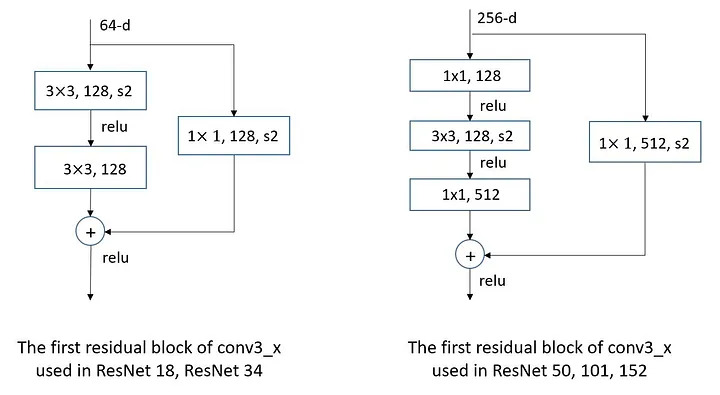

**在本次实验中，我们将定义一个 ResNet-34 网络用于 animals-10 数据集的分类。**

若你想查看别人实现的 ResNet 代码，可以自行阅读一些 github 上面成熟的开源项目或框架，如：

**torchvision** (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)

**detectron2** (https://github.com/facebookresearch/detectron2/blob/main/detectron2/modeling/backbone/resnet.py)

### PyTorch 模型定义

PyTorch 通过继承 ```Module``` 类来构造模型。```Module``` 类是 ```nn``` 模块里提供的一个模型构造类，是所有神经网络模块的基类，我们可以继承它来定义我们想要的模型。自定义的模型类会重载 ```Module``` 类的 ```__init__``` 函数和 ```forward``` 函数。它们分别用于创建模型参数和定义前向计算。前向计算即为正向传播。

类中无须定义反向传播函数。系统将通过自动求梯度而自动生成反向传播所需的 ```backward``` 函数。

若想更加详细地了解 PyTorch 框架是如何定义模型的，可以参考以下资料：


1. [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
2. [《动手学深度学习（PyTorch 版）》](https://github.com/ShusenTang/Dive-into-DL-PyTorch/blob/master/docs/chapter04_DL_computation/4.1_model-construction.md)


#### **残差块**

在开始定义 ResNet 之前，我们需要先定义一个可以在整个网络中重复使用的 ```ResidualBlock``` 模块。 该模块（**如上图左边的架构所示**）包含一个跳跃连接。残差块包含一个的可选参数（```downsample```）。

### 任务 3（10 Points）
请对 ```ResidualBlock``` 的 ```forward``` 函数进行补充。

In [14]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        """
        定义残差块。
        在 ResNet-18 和 ResNet-34 中，每个残差块包含 2 个 3*3 卷积。
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        """
        残差块的前向传播函数。输入 x 会通过 2 层卷积，得到的输出会与原输入进行残差求和。
        """
        
        """
        以下是一段空缺的代码，你需要对残差块类的 forward 函数进行补充。
        目标：
          1. 将输入 x 用变量 residual 存储起来，防止输入丢失
          2. 将输入 x 分别通过 2 层卷积层，得到输出 out
          3. 将经过卷积层的输出 out 与输入 residual 相加得到新的 out
          注意：如果 self.downsample 不为空，则需要在相加前将输入先用 self.downsample 函数处理residual。
               别忘了在合适的地方使用类里面已经初始化好的ReLU激活函数对输出进行非线性化处理。
          提示：大家可以参考上面给出的residual block的示意图来完成前向过程
        """
        # ========== 请在此处补充你的代码 ==========
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        out= self.conv2(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        
        # =======================================
        
        return out

### 测试代码3： 对`ResidualBlock.forward`进行测试
**以下代码用于验证 forward 函数的输出形状是否符合要求（仅验证了tensor的形状！）**

In [15]:
import copy

in_channels = [64, 64, 128, 128, 256, 256, 512]
out_channels = [64, 128, 128, 256, 256, 512, 512]
strides = [1, 2, 1, 2, 1, 2, 1]
downsamples = []
for i in range(len(strides)):
    if strides[i] != 1:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels[i], out_channels[i], kernel_size=1, stride=strides[i]),
            nn.BatchNorm2d(out_channels[i]),
        )
        downsamples.append(copy.deepcopy(downsample))
    else:
        downsamples.append(None)

your_rbs = [ResidualBlock(in_channels[i], out_channels[i], strides[i], downsamples[i]) for i in range(len(strides))]

tensor_sizes = [
    (1, 64, 56, 56),
    (1, 64, 56, 56),
    (1, 128, 28, 28),
    (1, 128, 28, 28),
    (1, 256, 14, 14),
    (1, 256, 14, 14),
    (1, 512, 7, 7),
    (1, 512, 7, 7),
]

print("【以下测试用例用于检验tensor的形状，不保证值正确】")
for i in range(len(strides)):
    print(f"以下是第{i+1}个测试用例，输入形状为{tensor_sizes[i]}，期望输出形状为{tensor_sizes[i+1]}")
    x = torch.randn(tensor_sizes[i])
    x_out = your_rbs[i](x)
    if x_out.shape == torch.Size(tensor_sizes[i+1]):
        print(f"第{i+1}个测试用例通过！")
    else:
        tup = tuple(torch.tensor(x_out.shape).detach().cpu().tolist())
        print(f"第{i+1}个测试用例未通过！你的输出tensor形状为{tup}")
    
del in_channels, out_channels, strides, downsamples, your_rbs, tensor_sizes

【以下测试用例用于检验tensor的形状，不保证值正确】
以下是第1个测试用例，输入形状为(1, 64, 56, 56)，期望输出形状为(1, 64, 56, 56)
第1个测试用例通过！
以下是第2个测试用例，输入形状为(1, 64, 56, 56)，期望输出形状为(1, 128, 28, 28)
第2个测试用例通过！
以下是第3个测试用例，输入形状为(1, 128, 28, 28)，期望输出形状为(1, 128, 28, 28)
第3个测试用例通过！
以下是第4个测试用例，输入形状为(1, 128, 28, 28)，期望输出形状为(1, 256, 14, 14)
第4个测试用例通过！
以下是第5个测试用例，输入形状为(1, 256, 14, 14)，期望输出形状为(1, 256, 14, 14)
第5个测试用例通过！
以下是第6个测试用例，输入形状为(1, 256, 14, 14)，期望输出形状为(1, 512, 7, 7)
第6个测试用例通过！
以下是第7个测试用例，输入形状为(1, 512, 7, 7)，期望输出形状为(1, 512, 7, 7)
第7个测试用例通过！


#### **ResNet 网络**

接下来我们将定义 ResNet 网络。

ResNet-34 中有 4 个卷积模块，分别包含了 3个、4个、6个 和 3个 残差块。这里创建了一个辅助函数 ```_make_layer``` 来定义每一个模块。在卷积层的后面，我们添加了一个平均池化层和线性层，用于实现图像分类。

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10, multi_scale=None):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.conv2_x = self._make_layer(block, 64, layers[0], stride = 1)
        self.conv3_x = self._make_layer(block, 128, layers[1], stride = 2)
        self.conv4_x = self._make_layer(block, 256, layers[2], stride = 2)
        self.conv5_x = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.multi_scale = multi_scale
        
    def _make_layer(self, block, planes, blocks, stride=1):
        """
        定义网络的每一层，包括 conv2_x, conv3_x, conv4_x 和 conv5_x。
        
        Args:
          block:  残差块类
          planes: 该层输出特征图的通道数
          blocks: 该层包含的残差块的数量
          stride: 该层下采样系数
        """
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        if self.multi_scale:
            return self.forward_multi_scale(x)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
    
    def forward_multi_scale(self, x):
        scales = [0.8, 1.0, 1.2]  # Example scales, you can modify this based on your requirements
        outputs = []
        for scale in scales:
            scaled_x = nn.functional.interpolate(x, scale_factor=scale, mode='bilinear', align_corners=False)
            out = self.forward_single_scale(scaled_x)
            outputs.append(out)
        return outputs

    def forward_single_scale(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## 训练和测试

### 超参数设置

在开始训练网络前，我们需要设置一些超参数。网络训练的的超参数包括 epoch、batch size、学习率等。可以通过搜索尝试的方式找出最佳的超参数。

In [17]:
"""
这里提供的超参数不一定是最优的超参数，建议自行对超参数的大小进行一下搜索。
"""
num_classes = 10  # 类别数
num_epochs = 130
learning_rate = 3e-4

model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)
model = model.to(device)

# 多 GPU 训练，在这里使用的是 nn.DataParallel
# 也可以使用 nn.parallel.DistributedDataParallel（官方建议）
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))
    
# 损失函数和优化器
"""
你可以自行尝试一些更为先进的优化器，如 Adam
"""
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 模型训练


现在，模型已经准备好进行训练了，在这里我们先了解一下在 PyTorch 中模型训练的步骤：

* 首先使用 <code>train_loader</code> 为每个批量加载输入的图像，并使用之前定义的设备变量 ```device``` 将数据移动到 GPU上

* 随后使用模型 ```model``` 对数据标签进行预测，使用之前定义的损失函数 ```criterion```  计算预测值与真实值之间的损失 

* 模型根据损失学习新的参数值，我们将损失值输入到反向传播方法中，<code>loss.backward()</code>，并更新权重，<code>optimizer.step()</code>。 每次更新之前，需要首先用 ```optimizer.zero_grad()``` 将参数的梯度设置为零，否则梯度会不断累积，之前计算得到的的梯度仍然存在（这是 PyTorch 的默认行为）

* 在每个 epoch 的最后，需要在验证集上测试模型，由于我们在评估时不需要梯度，因此可以使用 <code>torch.no_grad()</code> 将梯度计算关闭，加快模型推导速度。

### 任务 4（10 Points）
请对训练代码进行补充。

In [18]:
import gc

train_loss_lst, val_acc_lst = [], []

for epoch in range(num_epochs):
    if epoch == 115:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1*learning_rate)
    if epoch == 127:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01*learning_rate)
    with tqdm(train_loader, desc='Train [{}/{}]'.format(epoch+1, num_epochs), mininterval=1.0) as t:
        for images, labels in t:
            # 将数据移动至 GPU
            images = images.to(device)
            labels = labels.to(device)
            
            """
            以下是一段空缺的代码，你需要对模型训练代码进行补充。
            训练过程包括：
            1. 模型前向传播：输入图片到模型，得到输出
            2. 损失计算：基于模型输出和真实标签计算损失值
            3. 反向传播：对损失进行反向传播，并进行梯度更新（注意每次更新前需要先清空optimizer之前的梯度）
            """
            # ========== 请在此处补充你的代码 ==========
            
            #Zero the parameter gradients
            optimizer.zero_grad()
            
            #Forward pass
            outputs = model(images)
            
            #Calculate the loss
            loss = criterion(outputs,labels)
            
            #Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            
            # =======================================
            
            train_loss_lst.append(loss.item())
            t.set_postfix(loss=loss.item())
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # 每个 epoch 结束后都在验证集上进行验证，计算正确率
    with torch.no_grad():  # 不计算梯度
        correct = 0
        total = 0
        for images, labels in tqdm(val_loader, desc='Val', mininterval=1.0):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {:.4f} %'.format(len(val_dataset), 100 * correct / total))
        val_acc_lst.append(correct / total)

Train [1/130]: 100%|██████████| 67/67 [00:59<00:00,  1.12it/s, loss=2.07]


Epoch [1/130], Loss: 2.0742


Val: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Accuracy of the network on the 605 validation images: 28.9256 %


Train [2/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=2.15]


Epoch [2/130], Loss: 2.1482


Val: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Accuracy of the network on the 605 validation images: 32.3967 %


Train [3/130]: 100%|██████████| 67/67 [00:46<00:00,  1.43it/s, loss=1.42]


Epoch [3/130], Loss: 1.4172


Val: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Accuracy of the network on the 605 validation images: 34.2149 %


Train [4/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.97]


Epoch [4/130], Loss: 1.9710


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 39.8347 %


Train [5/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=2.1]


Epoch [5/130], Loss: 2.0962


Val: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Accuracy of the network on the 605 validation images: 41.9835 %


Train [6/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.79]


Epoch [6/130], Loss: 1.7899


Val: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Accuracy of the network on the 605 validation images: 46.4463 %


Train [7/130]: 100%|██████████| 67/67 [00:46<00:00,  1.43it/s, loss=1.77]


Epoch [7/130], Loss: 1.7658


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 49.5868 %


Train [8/130]: 100%|██████████| 67/67 [00:46<00:00,  1.43it/s, loss=2.06]


Epoch [8/130], Loss: 2.0617


Val: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Accuracy of the network on the 605 validation images: 47.2727 %


Train [9/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.8]


Epoch [9/130], Loss: 1.8045


Val: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Accuracy of the network on the 605 validation images: 51.5702 %


Train [10/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.49]


Epoch [10/130], Loss: 1.4948


Val: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Accuracy of the network on the 605 validation images: 52.5620 %


Train [11/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.93]


Epoch [11/130], Loss: 1.9320


Val: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Accuracy of the network on the 605 validation images: 53.0579 %


Train [12/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=2.16]


Epoch [12/130], Loss: 2.1619


Val: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Accuracy of the network on the 605 validation images: 52.8926 %


Train [13/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.46]


Epoch [13/130], Loss: 1.4647


Val: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 605 validation images: 57.3554 %


Train [14/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.42]


Epoch [14/130], Loss: 1.4214


Val: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Accuracy of the network on the 605 validation images: 56.1983 %


Train [15/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.86]


Epoch [15/130], Loss: 1.8649


Val: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Accuracy of the network on the 605 validation images: 56.6942 %


Train [16/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.59]


Epoch [16/130], Loss: 1.5947


Val: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 605 validation images: 56.3636 %


Train [17/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.39]


Epoch [17/130], Loss: 1.3897


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 58.1818 %


Train [18/130]: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s, loss=1.82]


Epoch [18/130], Loss: 1.8231


Val: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Accuracy of the network on the 605 validation images: 61.3223 %


Train [19/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=1.24]


Epoch [19/130], Loss: 1.2354


Val: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Accuracy of the network on the 605 validation images: 61.1570 %


Train [20/130]: 100%|██████████| 67/67 [00:51<00:00,  1.30it/s, loss=1.77]


Epoch [20/130], Loss: 1.7740


Val: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Accuracy of the network on the 605 validation images: 60.0000 %


Train [21/130]: 100%|██████████| 67/67 [00:52<00:00,  1.28it/s, loss=1.6]


Epoch [21/130], Loss: 1.5984


Val: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 605 validation images: 60.4959 %


Train [22/130]: 100%|██████████| 67/67 [00:50<00:00,  1.33it/s, loss=1.42]


Epoch [22/130], Loss: 1.4166


Val: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Accuracy of the network on the 605 validation images: 62.3140 %


Train [23/130]: 100%|██████████| 67/67 [00:52<00:00,  1.27it/s, loss=1.26]


Epoch [23/130], Loss: 1.2633


Val: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Accuracy of the network on the 605 validation images: 63.3058 %


Train [24/130]: 100%|██████████| 67/67 [00:52<00:00,  1.27it/s, loss=1.3]


Epoch [24/130], Loss: 1.3042


Val: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Accuracy of the network on the 605 validation images: 61.8182 %


Train [25/130]: 100%|██████████| 67/67 [00:51<00:00,  1.31it/s, loss=1.53]


Epoch [25/130], Loss: 1.5321


Val: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Accuracy of the network on the 605 validation images: 65.1240 %


Train [26/130]: 100%|██████████| 67/67 [00:53<00:00,  1.26it/s, loss=1.08]


Epoch [26/130], Loss: 1.0794


Val: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Accuracy of the network on the 605 validation images: 64.9587 %


Train [27/130]: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s, loss=1.71]


Epoch [27/130], Loss: 1.7094


Val: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Accuracy of the network on the 605 validation images: 64.7934 %


Train [28/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.38]


Epoch [28/130], Loss: 1.3765


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 65.1240 %


Train [29/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.53]


Epoch [29/130], Loss: 1.5311


Val: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Accuracy of the network on the 605 validation images: 64.6281 %


Train [30/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.15]


Epoch [30/130], Loss: 1.1511


Val: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Accuracy of the network on the 605 validation images: 68.4298 %


Train [31/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.67]


Epoch [31/130], Loss: 1.6661


Val: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Accuracy of the network on the 605 validation images: 63.9669 %


Train [32/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.17]


Epoch [32/130], Loss: 1.1727


Val: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Accuracy of the network on the 605 validation images: 66.7769 %


Train [33/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.27]


Epoch [33/130], Loss: 1.2730


Val: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Accuracy of the network on the 605 validation images: 66.2810 %


Train [34/130]: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s, loss=1.28]


Epoch [34/130], Loss: 1.2791


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 65.9504 %


Train [35/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.12]


Epoch [35/130], Loss: 1.1150


Val: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [36/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.23]


Epoch [36/130], Loss: 1.2340


Val: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 605 validation images: 66.2810 %


Train [37/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.2]


Epoch [37/130], Loss: 1.2004


Val: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 605 validation images: 67.4380 %


Train [38/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.09]


Epoch [38/130], Loss: 1.0852


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 68.4298 %


Train [39/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.776]


Epoch [39/130], Loss: 0.7765


Val: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Accuracy of the network on the 605 validation images: 68.2645 %


Train [40/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=1.55]


Epoch [40/130], Loss: 1.5453


Val: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Accuracy of the network on the 605 validation images: 68.7603 %


Train [41/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.965]


Epoch [41/130], Loss: 0.9650


Val: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [42/130]: 100%|██████████| 67/67 [00:50<00:00,  1.33it/s, loss=1.15]


Epoch [42/130], Loss: 1.1516


Val: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [43/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.736]


Epoch [43/130], Loss: 0.7365


Val: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy of the network on the 605 validation images: 66.7769 %


Train [44/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.48]


Epoch [44/130], Loss: 1.4760


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 68.9256 %


Train [45/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=1.42]


Epoch [45/130], Loss: 1.4242


Val: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [46/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.08]


Epoch [46/130], Loss: 1.0824


Val: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [47/130]: 100%|██████████| 67/67 [00:48<00:00,  1.40it/s, loss=1.34]


Epoch [47/130], Loss: 1.3396


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [48/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=1.1]


Epoch [48/130], Loss: 1.0950


Val: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [49/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.736]


Epoch [49/130], Loss: 0.7363


Val: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [50/130]: 100%|██████████| 67/67 [00:50<00:00,  1.33it/s, loss=1.27]


Epoch [50/130], Loss: 1.2654


Val: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Accuracy of the network on the 605 validation images: 72.3967 %


Train [51/130]: 100%|██████████| 67/67 [00:48<00:00,  1.37it/s, loss=1.29]


Epoch [51/130], Loss: 1.2874


Val: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [52/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.34]


Epoch [52/130], Loss: 1.3437


Val: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [53/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.707]


Epoch [53/130], Loss: 0.7070


Val: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [54/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.866]


Epoch [54/130], Loss: 0.8663


Val: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [55/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.832]


Epoch [55/130], Loss: 0.8316


Val: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [56/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.87]


Epoch [56/130], Loss: 1.8702


Val: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Accuracy of the network on the 605 validation images: 72.7273 %


Train [57/130]: 100%|██████████| 67/67 [00:48<00:00,  1.38it/s, loss=1.26]


Epoch [57/130], Loss: 1.2599


Val: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [58/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.36]


Epoch [58/130], Loss: 1.3605


Val: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Accuracy of the network on the 605 validation images: 74.7107 %


Train [59/130]: 100%|██████████| 67/67 [00:49<00:00,  1.36it/s, loss=0.958]


Epoch [59/130], Loss: 0.9585


Val: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Accuracy of the network on the 605 validation images: 76.3636 %


Train [60/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.889]


Epoch [60/130], Loss: 0.8885


Val: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Accuracy of the network on the 605 validation images: 72.8926 %


Train [61/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.687]


Epoch [61/130], Loss: 0.6873


Val: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Accuracy of the network on the 605 validation images: 74.2149 %


Train [62/130]: 100%|██████████| 67/67 [00:49<00:00,  1.34it/s, loss=0.881]


Epoch [62/130], Loss: 0.8808


Val: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Accuracy of the network on the 605 validation images: 73.3884 %


Train [63/130]: 100%|██████████| 67/67 [00:49<00:00,  1.35it/s, loss=1.35]


Epoch [63/130], Loss: 1.3483


Val: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 605 validation images: 73.0579 %


Train [64/130]: 100%|██████████| 67/67 [00:48<00:00,  1.40it/s, loss=1.4]


Epoch [64/130], Loss: 1.4032


Val: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Accuracy of the network on the 605 validation images: 73.8843 %


Train [65/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.09]


Epoch [65/130], Loss: 1.0898


Val: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [66/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.46]


Epoch [66/130], Loss: 1.4591


Val: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Accuracy of the network on the 605 validation images: 75.0413 %


Train [67/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.25]


Epoch [67/130], Loss: 1.2538


Val: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Accuracy of the network on the 605 validation images: 75.2066 %


Train [68/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.821]


Epoch [68/130], Loss: 0.8207


Val: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Accuracy of the network on the 605 validation images: 72.7273 %


Train [69/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.945]


Epoch [69/130], Loss: 0.9446


Val: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 605 validation images: 76.6942 %


Train [70/130]: 100%|██████████| 67/67 [00:52<00:00,  1.28it/s, loss=0.57]


Epoch [70/130], Loss: 0.5702


Val: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Accuracy of the network on the 605 validation images: 76.1983 %


Train [71/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.883]


Epoch [71/130], Loss: 0.8827


Val: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Accuracy of the network on the 605 validation images: 73.3884 %


Train [72/130]: 100%|██████████| 67/67 [00:52<00:00,  1.27it/s, loss=1.22]


Epoch [72/130], Loss: 1.2182


Val: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Accuracy of the network on the 605 validation images: 75.2066 %


Train [73/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.11]


Epoch [73/130], Loss: 1.1123


Val: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Accuracy of the network on the 605 validation images: 73.7190 %


Train [74/130]: 100%|██████████| 67/67 [00:48<00:00,  1.38it/s, loss=1.21]


Epoch [74/130], Loss: 1.2071


Val: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Accuracy of the network on the 605 validation images: 74.7107 %


Train [75/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.85]


Epoch [75/130], Loss: 0.8495


Val: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Accuracy of the network on the 605 validation images: 74.7107 %


Train [76/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.814]


Epoch [76/130], Loss: 0.8141


Val: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 605 validation images: 75.0413 %


Train [77/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.15]


Epoch [77/130], Loss: 1.1515


Val: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


Accuracy of the network on the 605 validation images: 77.3554 %


Train [78/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.18]


Epoch [78/130], Loss: 1.1784


Val: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Accuracy of the network on the 605 validation images: 76.3636 %


Train [79/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.769]


Epoch [79/130], Loss: 0.7686


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 76.6942 %


Train [80/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.28]


Epoch [80/130], Loss: 1.2826


Val: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Accuracy of the network on the 605 validation images: 76.1983 %


Train [81/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.03]


Epoch [81/130], Loss: 1.0324


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 74.5455 %


Train [82/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.917]


Epoch [82/130], Loss: 0.9170


Val: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [83/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.897]


Epoch [83/130], Loss: 0.8970


Val: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Accuracy of the network on the 605 validation images: 74.3802 %


Train [84/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.997]


Epoch [84/130], Loss: 0.9972


Val: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [85/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.738]


Epoch [85/130], Loss: 0.7376


Val: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Accuracy of the network on the 605 validation images: 76.6942 %


Train [86/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.24]


Epoch [86/130], Loss: 1.2432


Val: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Accuracy of the network on the 605 validation images: 77.6860 %


Train [87/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.506]


Epoch [87/130], Loss: 0.5064


Val: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Accuracy of the network on the 605 validation images: 76.3636 %


Train [88/130]: 100%|██████████| 67/67 [00:47<00:00,  1.43it/s, loss=1.12]


Epoch [88/130], Loss: 1.1176


Val: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Accuracy of the network on the 605 validation images: 78.1818 %


Train [89/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.49]


Epoch [89/130], Loss: 1.4873


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [90/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.978]


Epoch [90/130], Loss: 0.9777


Val: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Accuracy of the network on the 605 validation images: 77.1901 %


Train [91/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.36]


Epoch [91/130], Loss: 1.3617


Val: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Accuracy of the network on the 605 validation images: 76.3636 %


Train [92/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.676]


Epoch [92/130], Loss: 0.6759


Val: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 605 validation images: 76.1983 %


Train [93/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=1.29]


Epoch [93/130], Loss: 1.2926


Val: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy of the network on the 605 validation images: 78.3471 %


Train [94/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.463]


Epoch [94/130], Loss: 0.4632


Val: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [95/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.766]


Epoch [95/130], Loss: 0.7659


Val: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [96/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=1.56]


Epoch [96/130], Loss: 1.5626


Val: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Accuracy of the network on the 605 validation images: 76.0331 %


Train [97/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.92]


Epoch [97/130], Loss: 0.9198


Val: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Accuracy of the network on the 605 validation images: 75.8678 %


Train [98/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.645]


Epoch [98/130], Loss: 0.6449


Val: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Accuracy of the network on the 605 validation images: 77.8512 %


Train [99/130]: 100%|██████████| 67/67 [00:49<00:00,  1.36it/s, loss=0.513]


Epoch [99/130], Loss: 0.5129


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 76.0331 %


Train [100/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.632]


Epoch [100/130], Loss: 0.6321


Val: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Accuracy of the network on the 605 validation images: 78.5124 %


Train [101/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.73]


Epoch [101/130], Loss: 0.7304


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 78.3471 %


Train [102/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.986]


Epoch [102/130], Loss: 0.9863


Val: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Accuracy of the network on the 605 validation images: 78.6777 %


Train [103/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=1.01]


Epoch [103/130], Loss: 1.0077


Val: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Accuracy of the network on the 605 validation images: 77.0248 %


Train [104/130]: 100%|██████████| 67/67 [00:49<00:00,  1.36it/s, loss=1.28]


Epoch [104/130], Loss: 1.2821


Val: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Accuracy of the network on the 605 validation images: 75.5372 %


Train [105/130]: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s, loss=0.973]


Epoch [105/130], Loss: 0.9727


Val: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [106/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.984]


Epoch [106/130], Loss: 0.9841


Val: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Accuracy of the network on the 605 validation images: 77.3554 %


Train [107/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.858]


Epoch [107/130], Loss: 0.8580


Val: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Accuracy of the network on the 605 validation images: 78.3471 %


Train [108/130]: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s, loss=0.581]


Epoch [108/130], Loss: 0.5807


Val: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Accuracy of the network on the 605 validation images: 77.0248 %


Train [109/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.92]


Epoch [109/130], Loss: 0.9196


Val: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Accuracy of the network on the 605 validation images: 77.1901 %


Train [110/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.665]


Epoch [110/130], Loss: 0.6649


Val: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Accuracy of the network on the 605 validation images: 76.3636 %


Train [111/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.27]


Epoch [111/130], Loss: 1.2748


Val: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 605 validation images: 76.6942 %


Train [112/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.536]


Epoch [112/130], Loss: 0.5364


Val: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Accuracy of the network on the 605 validation images: 76.5289 %


Train [113/130]: 100%|██████████| 67/67 [00:46<00:00,  1.43it/s, loss=0.709]


Epoch [113/130], Loss: 0.7095


Val: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 605 validation images: 78.8430 %


Train [114/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.7]


Epoch [114/130], Loss: 0.6997


Val: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Accuracy of the network on the 605 validation images: 78.0165 %


Train [115/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.917]


Epoch [115/130], Loss: 0.9166


Val: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Accuracy of the network on the 605 validation images: 79.3388 %


Train [116/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.478]


Epoch [116/130], Loss: 0.4782


Val: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Accuracy of the network on the 605 validation images: 79.0083 %


Train [117/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.493]


Epoch [117/130], Loss: 0.4934


Val: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Accuracy of the network on the 605 validation images: 79.5041 %


Train [118/130]: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s, loss=0.683]


Epoch [118/130], Loss: 0.6833


Val: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Accuracy of the network on the 605 validation images: 80.4959 %


Train [119/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.514]


Epoch [119/130], Loss: 0.5137


Val: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Accuracy of the network on the 605 validation images: 79.6694 %


Train [120/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=1.08]


Epoch [120/130], Loss: 1.0812


Val: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Accuracy of the network on the 605 validation images: 78.6777 %


Train [121/130]: 100%|██████████| 67/67 [00:55<00:00,  1.20it/s, loss=0.672]


Epoch [121/130], Loss: 0.6717


Val: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Accuracy of the network on the 605 validation images: 79.6694 %


Train [122/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.482]


Epoch [122/130], Loss: 0.4821


Val: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 605 validation images: 79.6694 %


Train [123/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.703]


Epoch [123/130], Loss: 0.7030


Val: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Accuracy of the network on the 605 validation images: 80.3306 %


Train [124/130]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s, loss=0.794]


Epoch [124/130], Loss: 0.7935


Val: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Accuracy of the network on the 605 validation images: 79.1736 %


Train [125/130]: 100%|██████████| 67/67 [00:47<00:00,  1.42it/s, loss=0.607]


Epoch [125/130], Loss: 0.6069


Val: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Accuracy of the network on the 605 validation images: 79.0083 %


Train [126/130]: 100%|██████████| 67/67 [00:49<00:00,  1.34it/s, loss=1.03]


Epoch [126/130], Loss: 1.0264


Val: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Accuracy of the network on the 605 validation images: 79.8347 %


Train [127/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.711]


Epoch [127/130], Loss: 0.7110


Val: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Accuracy of the network on the 605 validation images: 78.8430 %


Train [128/130]: 100%|██████████| 67/67 [00:47<00:00,  1.41it/s, loss=0.601]


Epoch [128/130], Loss: 0.6006


Val: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Accuracy of the network on the 605 validation images: 79.0083 %


Train [129/130]: 100%|██████████| 67/67 [00:49<00:00,  1.35it/s, loss=0.782]


Epoch [129/130], Loss: 0.7817


Val: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Accuracy of the network on the 605 validation images: 79.0083 %


Train [130/130]: 100%|██████████| 67/67 [00:52<00:00,  1.28it/s, loss=0.422]


Epoch [130/130], Loss: 0.4221


Val: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

Accuracy of the network on the 605 validation images: 79.3388 %


### 训练损失曲线可视化

以下的代码用于将训练过程中训练集上的损失以及验证集上的精确度可视化为曲线，并展示结果。

In [19]:
def learning_curve(train_loss_lst, val_acc_lst, num_epochs, multi_times, _ylabel1='train loss', _ylabel2='val acc', smooth_factor=10):
    """
    Args:
        smooth_factor: 平滑因子，只能取正整数。平滑因子越大，损失曲线越平滑
    """
    
    assert smooth_factor > 0 and type(smooth_factor) == int
    
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(_ylabel1, color=color)
    train_loss_x = [i/multi_times for i in range(num_epochs*multi_times)]
    ax1.plot(train_loss_x[::smooth_factor], train_loss_lst[::smooth_factor], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

    color = 'tab:red'
    ax2.set_ylabel(_ylabel2, color=color)
    val_acc_x = [i for i in range(1, num_epochs+1)]
    ax2.plot(val_acc_x, val_acc_lst, color=color, marker = 'x')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


========================= LEARNING CURVE =======================


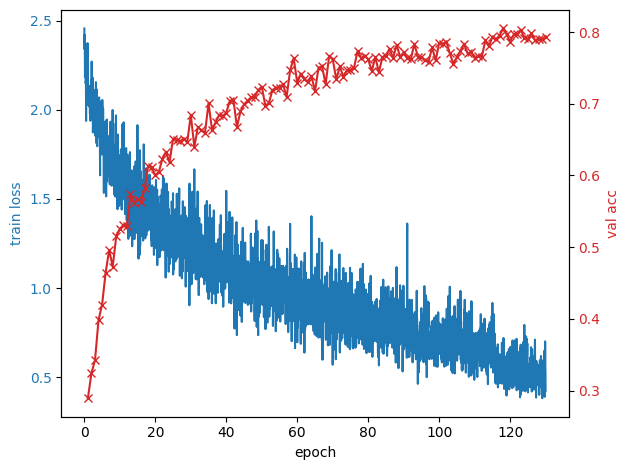

In [20]:
len_train_loss = len(train_loss_lst)
len_val_acc = len(val_acc_lst)
multi_times = len_train_loss // len_val_acc

print('========================= LEARNING CURVE =======================')
learning_curve(train_loss_lst, val_acc_lst, num_epochs, multi_times, smooth_factor=3)

### 模型测试

对于测试，我们可以采用跟验证阶段相同的代码，不过 dataloader 更改为 <code>test_loader</code>，并且不需要进行梯度回传。

### 任务 5（30 Points）
请自行调节模型训练的超参数、优化器等，使得模型在测试集上的准确率尽可能高。

分段给分（计分时准确率四舍五入保留到小数点后2位，例如0.623计为0.62）：

| Baseline  | Accuracy        | Score  |
| :---:     |    :----:       |  :---: |
| Vallina   | \[0.45, 0.63\]  |   15   |
| Simple    | (0.63, 0.70\]   |   18   |
| Medium    | (0.70, 0.77\]   |   20   |
| Hard      | (0.77, 0.83\]   |   25   |
| Strong    | (0.83, 1.00\]   |   30   |

In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader, desc='Test', mininterval=1.0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {:.4f} %'.format(len(test_dataset), 100 * correct / total))   

Test: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]

Accuracy of the network on the 1211 test images: 83.8150 %


#### **结果可视化**

In [22]:
# 选择测试集的一个子集进行可视化
num_images_to_show = 24

newClass = classes

19it [00:06,  3.06it/s]


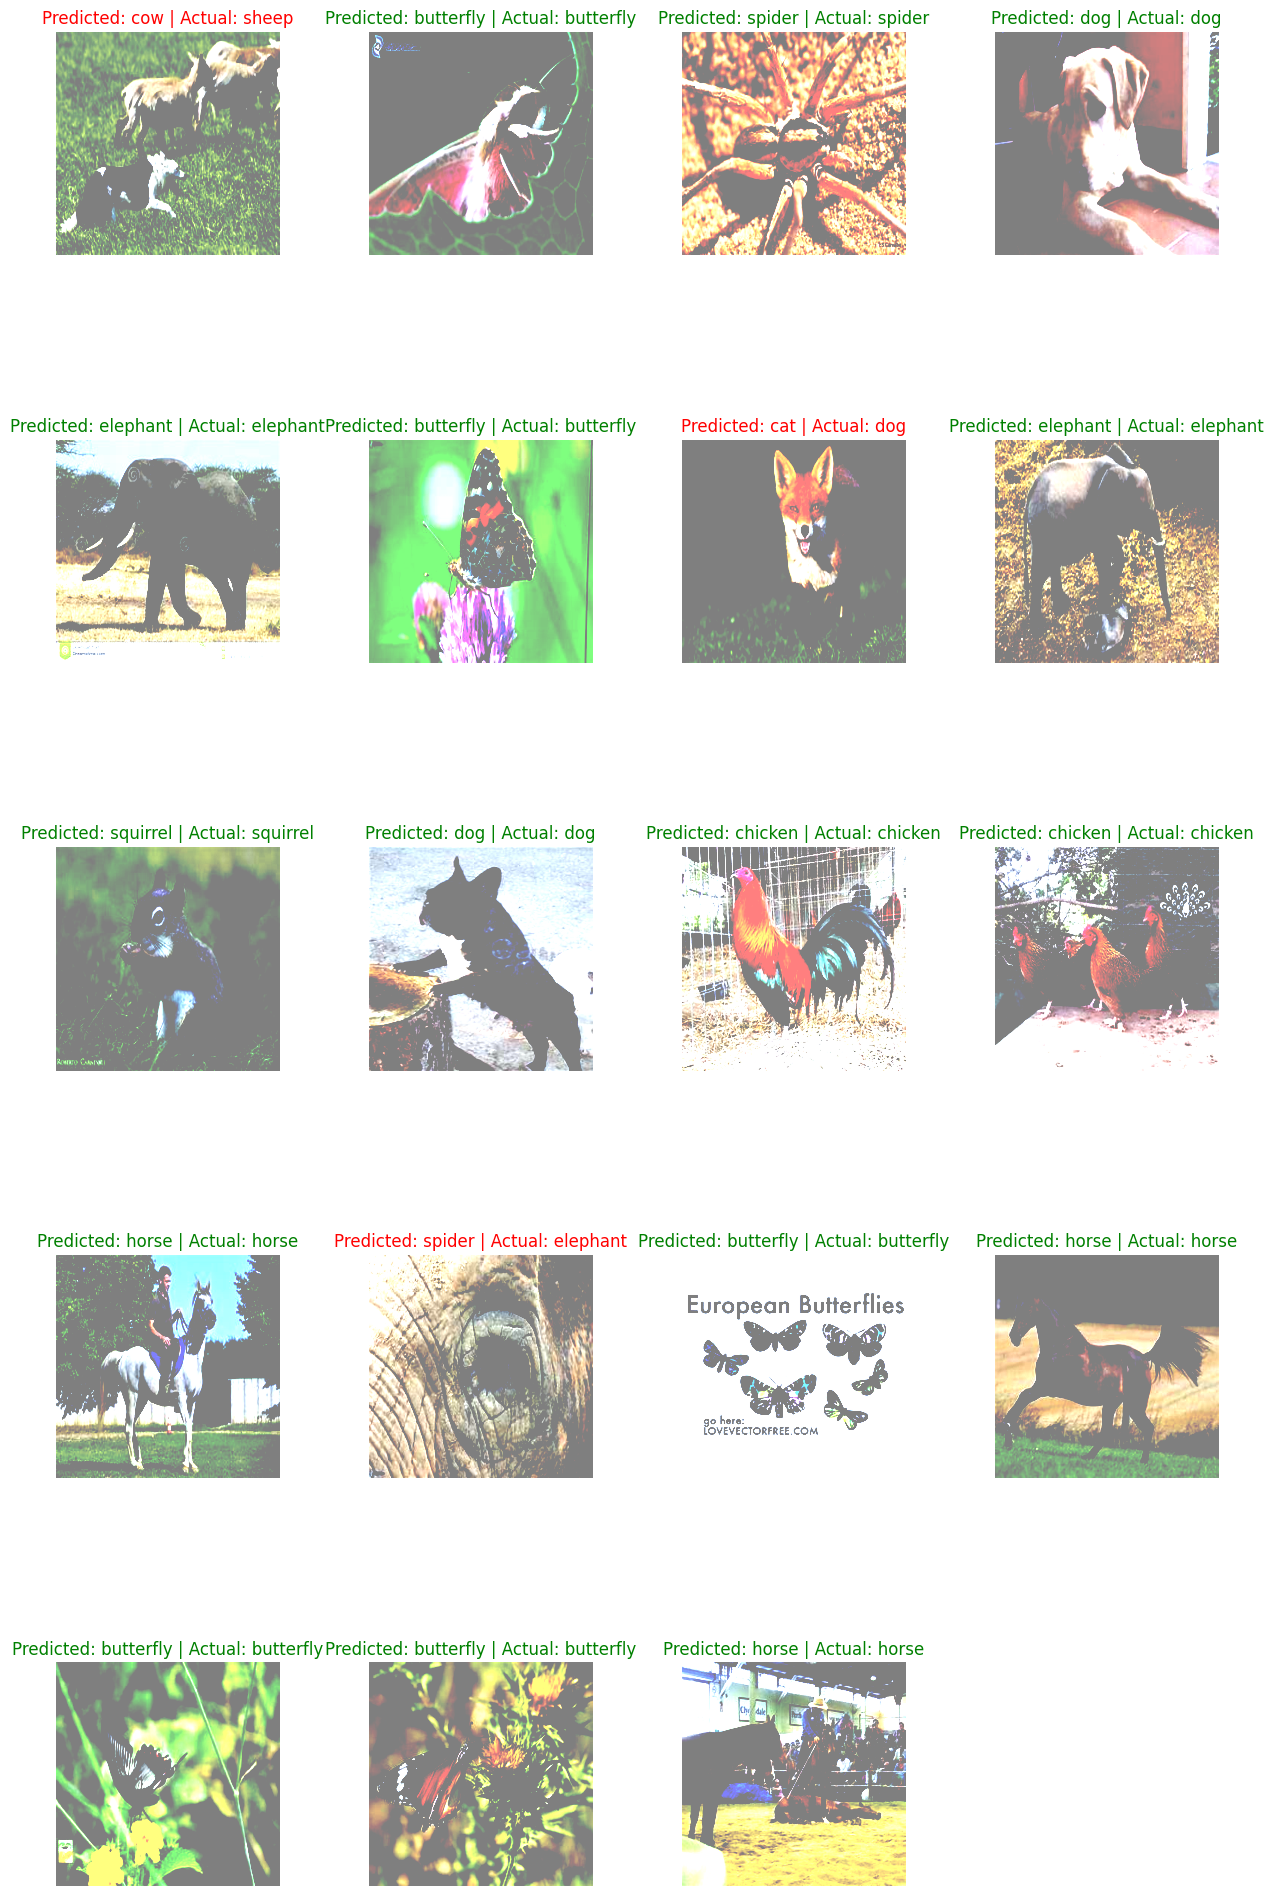

In [23]:
# Make predictions and plot images with predicted labels
plt.figure(figsize=(15, 30))
for i, (image, label) in tqdm(enumerate(test_loader, 1)):
    if i > 24:
        break
        
    with torch.no_grad():
        images = image.to(device)
        labels = label.to(device)
        output =  model(images)
        _, predicted = torch.max(output.data, 1)
        
        plt.subplot(6, 4, i)
        
        # Ensure pixel values are in the [0, 1] range
        image = torch.clamp(image, 0, 1)
        plt.imshow((image[0] * 0.5 + 0.5).permute(1, 2, 0))
        if(newClass[predicted[0]]==newClass[label[0]]):
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="green")
        else:
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="red")
       
        plt.axis('off')
    
        if i > num_images_to_show:
            break

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

#### **模型保存**

In [24]:
torch.save(model.state_dict(), "/kaggle/working/resnet_34.pth")

#### **模型下载**
保存好模型后需要大家从kaggle下载到本地，并提交。

下载模型的操作如下：

1. 首先在右侧Output下找到路径”/kaggle/working“，并刷新（不然，模型参数可能是之前保存的旧值）
<div style="text-align:center;">
    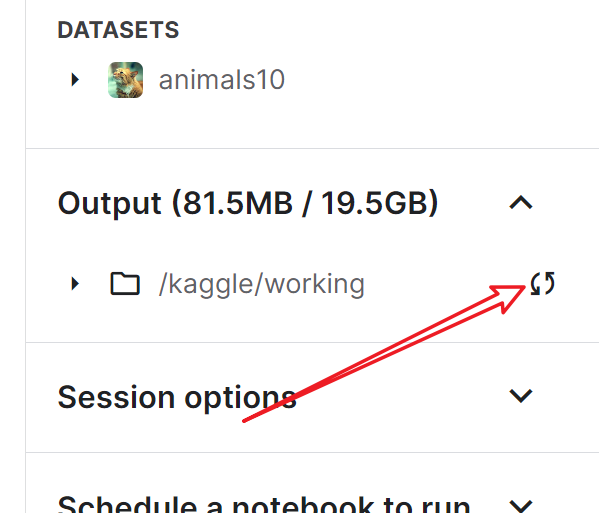
</div>
2. 然后在”/kaggle/working“目录下找到文件"resnet_34.pth"并下载到本地：
<div style="text-align:center;">
    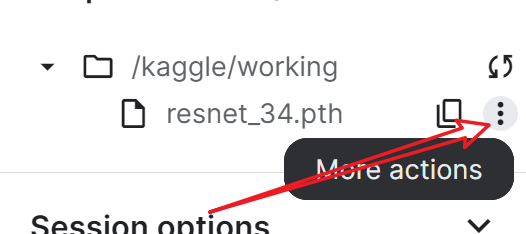
</div>